In [6]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import random
from gym import spaces, utils, logger
import gym
from collections import OrderedDict
from collections import deque
from termcolor import colored
import textwrap
import pickle




In [2]:
# HELPER FUNCTIONS

# Moving Average
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n



---

In [140]:
# ENVIRONMENT : CLASS DEFINITION


# Class Definition
class ProteinFoldingEnv(gym.Env):
    def __init__(self, sequence, valid_state_reward = 0.1, collision_reward=0, fig_size=(6, 6)):
        """Initialize new Environement."""
        # Environment Variables
        self.sequence = sequence.upper()
        self.size = len(sequence)
        self.fig_size = fig_size
        self.valid_state_reward = valid_state_reward
        self.collision_reward = collision_reward
        self.ACTION_TO_STR = {0 : 'Left', 1 : 'Forward', 2 : 'Right'}

        # Agent Variables
        self.state = [(0,0), (0,1)] # Initial state is [(0,0), (0,1)] in order to force an initial direction and reduce state space by factor 1/3
        self.actions = [] # list of ordered actions taken during an episode
        self.is_collision = False # Check presence of collision to end an episode
        self.reward = 0 # counts reward during an episode
        
        # Action Space & Observation Space
        self.action_space = spaces.Discrete(3) # action space of size 3
        self.loc = (0,1) # Last Position on the chain. Initial value is (0,1) (from initial state [(0,0), (0,1)])
        self.direction = 1 # Initial direction is 'Forward'
        self.iter = 0 # counts number of iterations or steps in the episode

        
    def reset(self):
        """Reset Environment to initial values."""
        self.state = [(0,0), (0,1)]
        self.actions = []
        self.reward = 0
        self.is_collision = False
        self.loc = (0,1)
        self.direction = 1
        self.iter = 0
        return copy.copy(self.state)

        
    def step(self, action):
        """Advance the agent to the next state using the input action."""
        # Get Next Location
        self.loc, self.direction = self._get_next_loc(self.loc, self.direction, action)  
        # Check Collision
        if self.loc in self.state:
            self.is_collision = True
        # Update
        self.iter += 1
        self.state.append(self.loc)
        self.actions.append(action)            
        # Set Done Parameter
        done = True if (self.iter+2 == self.size) or self.is_collision else False  
        # Compute Reward of (state, action) pair
        reward = self._compute_reward(done)
        self.reward += reward # adds reward to total reward of episode
        # Fill in Information
        info = {
            'chain_length' : self.iter + 2,
            'seq_length'   : self.size,
            'is_collision' : self.is_collision,
            'actions'      : [self.ACTION_TO_STR[i] for i in self.actions],
            'state'  : self.state
        }
        
        return (copy.copy(self.state), reward, done, info)

    
    def _get_next_loc(self, loc, direction, action):
        """Update Environment with respect to input action."""
        # Update Direction
        if action == 0:
            next_direction = (direction - 1)%4
        elif action == 2:
            next_direction = (direction + 1)%4
        else:
            next_direction = direction        
        # Update Last Location
        if next_direction == 0:
            next_loc = (loc[0]-1, loc[1])
        elif next_direction == 1:
            next_loc = (loc[0], loc[1]+1)
        elif next_direction == 2:
            next_loc = (loc[0]+1, loc[1])
        else:
            next_loc = (loc[0], loc[1]-1)
 
        return next_loc, next_direction

    
    def _is_neighbors(self, tuple_1, tuple_2):
        """Check if two tuples are neighbors on the grid."""
        if abs(tuple_1[0] - tuple_2[0]) + abs(tuple_1[1] - tuple_2[1]) == 1:
            return True      
        return False

    
    def _compute_energy(self):
        """Compute energy at the end of episode."""
        E = 0
        for i in range(self.size-2):
            for j in range(i+2, self.size):
                if (self.sequence[i] == 'H') and (self.sequence[j] == 'H') and self._is_neighbors(self.state[i], self.state[j]):
                    E -= 1
        return E

    
    def _compute_reward(self, done):
        """Compute reward of the transition."""
        r = 0
        if self.is_collision: # if new state is not valid (exists already), add collision penalty
            r += self.collision_reward
        elif done: # If we reach the end of the sequence with no collisions, add -energy and valid state reward
            r = r + self.valid_state_reward - self._compute_energy()
        else: # If new state is valid and episode not done yet, add reward for valid step
            r += self.valid_state_reward
        return r
    
    
    def summary(self):
        texts = []
        texts.append(colored('\n{:^90}'.format('ENVIRONMENT SUMMARY') , attrs=['reverse', 'bold']))
        texts.append(colored(' Sequence   :', 'green', attrs=['reverse','bold']) + ' ' + ' '.join([colored(char, 'blue', attrs=['bold']) if char=='P' else colored(char, 'red', attrs=['bold']) for char in self.sequence]))
        texts.append(colored(' Length     :', 'green', attrs=['reverse','bold']) + ' ' + colored(str(self.size), attrs=['bold']))
        texts.append(colored(' Collision  :', 'green', attrs=['reverse','bold']) + ' ' + colored(self.is_collision, attrs=['bold']))
        texts.append(colored(' Energy     :', 'green', attrs=['reverse','bold']) + ' ' + colored(str(self._compute_energy()), attrs=['bold']))
        texts.append(colored(' Reward     :', 'green', attrs=['reverse','bold']) + ' ' + colored(str(round(self.reward, 2)), attrs=['bold']))        
        texts.append(colored(' Iteration  :', 'green', attrs=['reverse','bold']) + ' ' + colored(str(self.iter), attrs=['bold']))                
        actions = colored(' > '.join([colored(self.ACTION_TO_STR[i], 'cyan', attrs=['bold']) if self.ACTION_TO_STR[i] == 'Forward' \
                                                                                                  else colored(self.ACTION_TO_STR[i], 'magenta', attrs=['bold']) if self.ACTION_TO_STR[i] == 'Left' \
                                                                                                  else colored(self.ACTION_TO_STR[i], 'yellow', attrs=['bold']) for i in self.actions]), attrs=['bold'])
        actions = textwrap.wrap(actions, width=200)
        actions = [(14* ' ') + line if ix > 0 else line for ix,line in enumerate(actions)]
        texts.append(colored(' Actions    :', 'green', attrs=['reverse','bold']) + ' ' + '\n'.join(actions))
        texts.append(colored(90*' ', attrs=['reverse', 'bold']))
        
        return '\n'.join(texts)

    
    def render(self):
        """Visualizes the current state of the environment."""
        H_x = [el[0] for idx, el in enumerate(self.state) if self.sequence[idx]=='H']
        H_y = [el[1] for idx, el in enumerate(self.state) if self.sequence[idx]=='H']
        # Polar amino-acids : coordinates
        P_x = [el[0] for idx, el in enumerate(self.state) if self.sequence[idx]=='P']
        P_y = [el[1] for idx, el in enumerate(self.state) if self.sequence[idx]=='P']
        # Total chain coordinates
        T_x = [el[0] for el in self.state] 
        T_y = [el[1] for el in self.state]
        # Visualize
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=self.fig_size)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.patch.set_facecolor('#222831')
        ax.plot(T_x, T_y, '.--', color='white', linewidth=.6)
        ax.scatter(H_x, H_y, s=400, facecolor='tab:red', label='H')
        ax.scatter(P_x, P_y, s=400, facecolor='tab:blue', label='P')
        ax.annotate(s='Start', xy=(0,0), xytext=(0.1, -0.35), color='white', weight='bold')
        ax.annotate(s='End', xy=self.loc, xytext=(self.loc[0]+0.1, self.loc[1]-0.35), color='white', weight='bold')
        plt.xlim(min(T_x)-1, max(T_x)+1)
        plt.ylim(min(T_y)-1, max(T_y)+1)
        ax.legend(markerscale=.5)
        plt.show();
        return None

In [142]:
# Q-LEARNING AGENT : CLASS DEFINITION
class QAgent:
    def __init__(self, state_size, action_size, alpha = 1.0, gamma = 0.9, epsilon = 1.0, epsilon_min = 0.05, epsilon_decay = 0.99985):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma                                # discount rate
        self.epsilon = epsilon                            # exploration rate
        self.epsilon_min = epsilon_min                    # minimum exploration rate
        self.epsilon_decay = epsilon_decay                # exploration rate decay
        self.alpha = alpha                                # learning rate
        self.Q = OrderedDict({((0,0),(0,1)) : [0, 0, 0]}) # Initial State : ((0,0), (0,1))

    def act(self, state, policy='egreedy'):
        """Method to get action according to a policy."""
        if policy == 'egreedy' : # e-greedy policy
            # With probability (1-epsilon), take the best action (exploit, Greedy Policy)
            if np.random.uniform(0, 1) > self.epsilon: 
                action = np.argmax(self.Q[tuple(state)])
            # With probability epsilon, take random action (explore)
            else: 
                action = np.random.choice(self.action_size)
        else : # greedy policy
            action = np.argmax(self.Q[tuple(state)])
        return action 
    
    def train(self, state, action, reward, next_state):
        """Method to update the Q entries."""
        # Check if next_state is in Q, if not add it
        if tuple(next_state) not in self.Q.keys():
            self.Q[tuple(next_state)] = [0, 0, 0]
        # Compute Q(next_state, :)
        next_Q = self.Q[tuple(next_state)]
        # Update Q entry of Current State
        self.Q[tuple(state)][action] = (1 - self.alpha) * self.Q[tuple(state)][action] + self.alpha * (reward + self.gamma * np.max(next_Q))
        return None

In [115]:
pow(.999925, 50000)

0.023514438740122757

In [143]:
# INITIATE SEQUENCES
seq1 = 'HHPPHH' # target energy : -2 | target reward : 2.4
seq2 = 'HPPHPPPH' # target energy : 
seq3 = 'HHPHPHPPPH' # target energy : -3 | target reward : 3.8
seq4 = 'HPHPPHHPHPPHPH' # target energy : -6 | target reward : 7.2
seq5 = 'HPHPPHHPHPPHPHHPPHPH' # target energy : -9 | target reward : 10.8
seq6 = 'PPPHHPPHHPPPPPHHHHHHHPPHHPPPPHHPPHPP' # target energy : -14 | target reward : 17.4

In [144]:
############################################## Q-LEARNING : EXPERIMENT ##############################################

# CREATE ENVIRONMENT
env = ProteinFoldingEnv(seq6, valid_state_reward = 0.1, collision_reward = -1) 

# CREATE Q-LEARNING AGENT
state_size = env.size - 2
action_size = env.action_space.n
qAgent = QAgent(state_size, action_size, epsilon_decay=0.9999965, alpha=0.8)
#9999985 == 2,000,000 #.9999965 == 1,000,000 #.999985 == 200,000 #.999925 == 50,000

# TRAIN AGENT
EPISODES = 1000000
qRewards = []
for episode in range(1, EPISODES+1):
    if episode%10000 == 0 : print("Episode :", episode)
    state = env.reset()
    done = False
    while not done:
        # Pick Next Action (via e-greedy policy)
        action = qAgent.act(state, policy='egreedy') 
        # Advance to next step
        next_state, reward, done, info = env.step(action) 
        # Update Q entries
        qAgent.train(state, action, reward, next_state)
        #print('State : {} --> Q Values : {}'.format(state, qAgent.Q[tuple(state)]))
        state = next_state
    
    if qAgent.epsilon >= qAgent.epsilon_min : qAgent.epsilon *= qAgent.epsilon_decay
    qRewards.append(env.reward) 

print('\nTraining Finished !')

Episode : 10000
Episode : 20000
Episode : 30000
Episode : 40000
Episode : 50000
Episode : 60000
Episode : 70000
Episode : 80000
Episode : 90000
Episode : 100000
Episode : 110000
Episode : 120000
Episode : 130000
Episode : 140000
Episode : 150000
Episode : 160000
Episode : 170000
Episode : 180000
Episode : 190000
Episode : 200000
Episode : 210000
Episode : 220000
Episode : 230000
Episode : 240000
Episode : 250000
Episode : 260000
Episode : 270000
Episode : 280000
Episode : 290000
Episode : 300000
Episode : 310000
Episode : 320000
Episode : 330000
Episode : 340000
Episode : 350000
Episode : 360000
Episode : 370000
Episode : 380000
Episode : 390000
Episode : 400000
Episode : 410000
Episode : 420000
Episode : 430000
Episode : 440000
Episode : 450000
Episode : 460000
Episode : 470000
Episode : 480000
Episode : 490000
Episode : 500000
Episode : 510000
Episode : 520000
Episode : 530000
Episode : 540000
Episode : 550000
Episode : 560000
Episode : 570000
Episode : 580000
Episode : 590000
Episod

In [121]:
#with open('/Users/Samyer/Documents/Projects/Protein-Folding-Problem/agent.pickle', 'rb') as handle:
#    qAgent = pickle.load(handle)

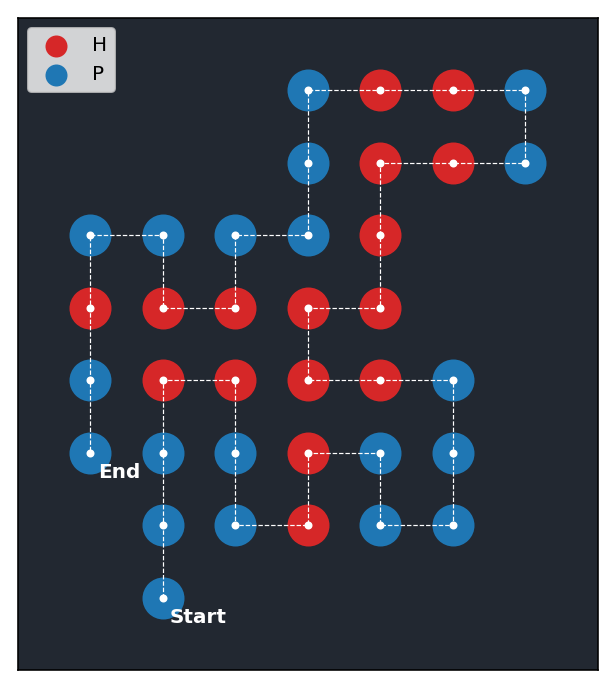


                                   ENVIRONMENT SUMMARY                                    
 Sequence   : P P P H H P P H H P P P P P H H H H H H H P P H H P P P P H H P P H P P
 Length     : 36
 Collision  : False
 Energy     : -9
 Reward     : 12.4
 Iteration  : 34
 Actions    : Forward > Forward > Right > Right > Forward > Left > Left > Right > Right >
              Left > Left > Forward > Left > Forward > Right > Right > Left > Forward >
              Right > Forward > Left > Left > Forward > Forward > Left > Forward > Right >
              Left > Right > Right > Left > Left > Forward > Forward
                                                                                          


In [145]:
# TEST AGENT
env = ProteinFoldingEnv(seq6, valid_state_reward = 0.1, collision_reward = 0)
state = env.reset()

done = False
while not done:
    # Pick Next Action (via greedy policy)
    action = qAgent.act(state, policy='greedy')
    # Advance to next step
    state, reward, done, info = env.step(action)
env.render()
print(env.summary())

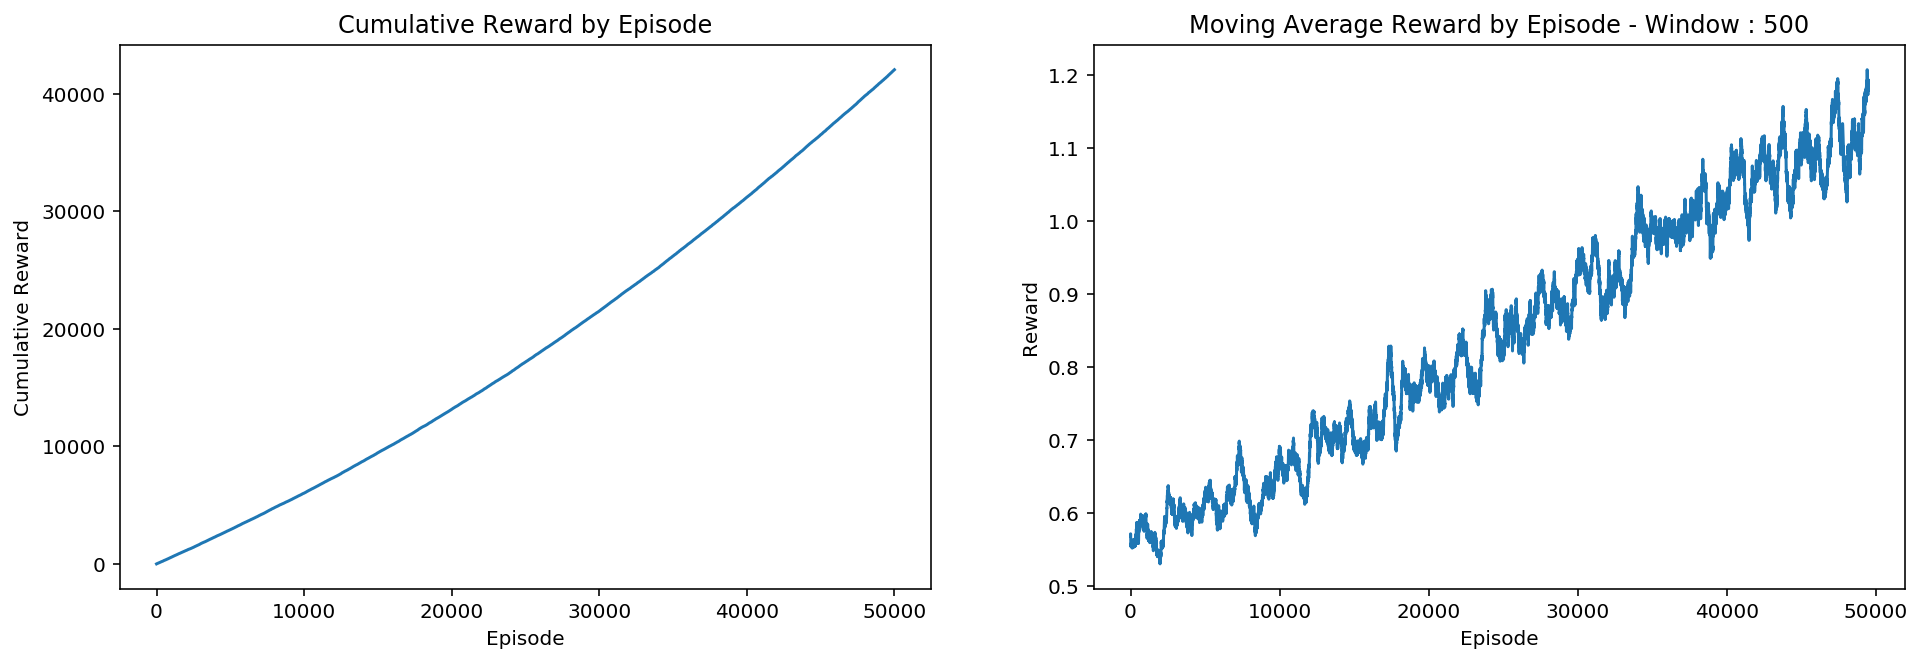

In [139]:
# EVALUATE LEARNING PERFORMANCE
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
qRewards_cum = np.cumsum(qRewards)
plt.plot(qRewards_cum)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward by Episode')

plt.subplot(1,2,2)
step = int(EPISODES/100)
qRewards_ma = moving_average(qRewards, step)
plt.plot(qRewards_ma)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Moving Average Reward by Episode - Window : {}'.format(step));

In [406]:
#with open('/Users/Samyer/Documents/Projects/Protein-Folding-Problem/agent.pickle', 'wb') as handle:
#    pickle.dump(qAgent, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [379]:
texts = []
texts.append(colored('Sequence   :', 'green', attrs=['reverse', 'bold']) + ' ' + ' '.join([colored(char, 'red', attrs=['bold']) if char=='P' else colored(char, 'blue', attrs=['bold']) for char in env.sequence]))
texts.append(colored('Length     :', 'green', attrs=['reverse', 'bold']) + ' ' + colored(str(env.size), attrs=['bold']))
texts.append(colored('Collision  :', 'green', attrs=['reverse', 'bold']) + ' ' + colored(env.is_collision, attrs=['bold']))
texts.append(colored('Energy     :', 'green', attrs=['reverse', 'bold']) + ' ' + colored(str(env._compute_energy()), attrs=['bold']))
texts.append(colored('Reward     :', 'green', attrs=['reverse', 'bold']) + ' ' + colored(str(round(reward,2)), attrs=['bold']))
texts.append(colored('Actions    :', 'green', attrs=['reverse', 'bold']) + ' ' + colored(' > '.join([ACTION_TO_STR[i] for i in env.actions]), attrs=['bold']))
texts.append(colored('State      :', 'green', attrs=['reverse', 'bold']) + ' ' + colored(' - '.join([str(t) for t in env.state]),  attrs=['bold']))

print('\n'.join(texts))

Sequence   : P P P H H P P H H P P P P P H H H H H H H P P H H P P P P H H P P H P P
Length     : 36
Collision  : False
Energy     : -10
Reward     : 10.1
Actions    : Left > Right > Right > Forward > Left > Left > Forward > Right > Right > Left > Left > Right > Forward > Right > Right > Left > Left > Right > Right > Forward > Left > Left > Forward > Right > Left > Left > Forward > Forward > Forward > Right > Left > Left > Right > Left
State      : (0, 0) - (0, 1) - (-1, 1) - (-1, 2) - (0, 2) - (1, 2) - (1, 3) - (0, 3) - (-1, 3) - (-1, 4) - (0, 4) - (0, 5) - (-1, 5) - (-1, 6) - (-1, 7) - (0, 7) - (0, 6) - (1, 6) - (1, 7) - (2, 7) - (2, 6) - (2, 5) - (3, 5) - (3, 6) - (3, 7) - (4, 7) - (4, 8) - (3, 8) - (2, 8) - (1, 8) - (0, 8) - (0, 9) - (-1, 9) - (-1, 8) - (-2, 8) - (-2, 7)


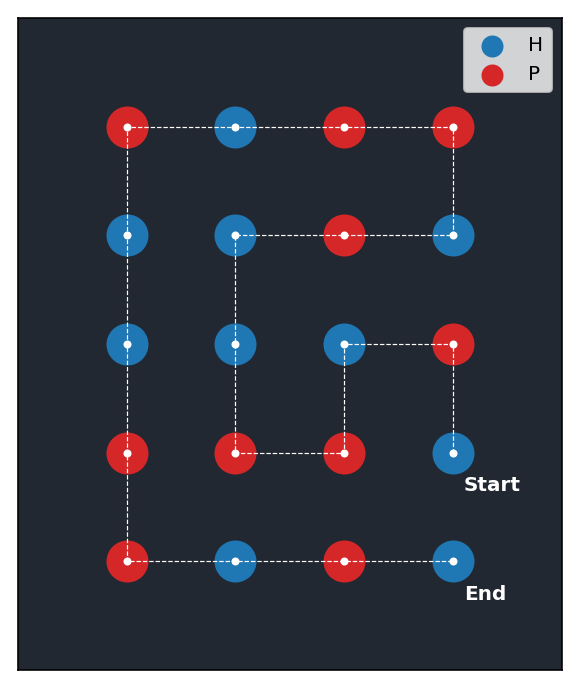

In [62]:
H_x = [el[0] for idx, el in enumerate(env.state) if env.sequence[idx]=='H']
H_y = [el[1] for idx, el in enumerate(env.state) if env.sequence[idx]=='H']
# Polar amino-acids : coordinates
P_x = [el[0] for idx, el in enumerate(env.state) if env.sequence[idx]=='P']
P_y = [el[1] for idx, el in enumerate(env.state) if env.sequence[idx]=='P']
# Total chain coordinates
T_x = [el[0] for el in env.state] 
T_y = [el[1] for el in env.state]
# Visualize
#fig = plt.figure(figsize=(6,6))
#ax = fig.add_subplot(111)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
#ax.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
ax.patch.set_facecolor('#222831')
ax.plot(T_x, T_y, '.--', color='white', linewidth=.6)
ax.scatter(H_x, H_y, s=400, facecolor='tab:blue', label='H')
ax.scatter(P_x, P_y, s=400, facecolor='tab:red', label='P')
ax.annotate(s='Start', xy=(0,0), xytext=(0.1,-0.35), color='white', weight='bold')
ax.annotate(s='End', xy=env.loc, xytext=(env.loc[0]+.1, env.loc[1]-.35), color='white', weight='bold')
plt.xlim(min(T_x)-1, max(T_x)+1)
plt.ylim(min(T_y)-1, max(T_y)+1)
ax.legend(markerscale=.5)
plt.show();

In [42]:
env.fig_size[0]

(6, 6)

In [44]:
max(T_y)+1
(min(T_y)-1)
max(T_y)+1 - (min(T_y)-1)

2

-2

4

In [46]:
(-.4, -.6)
(-.3, -.6)

0.75